# Llama-3.2-11B-Vision-Instruct

In [ ]:
# Inference section must be on 3.10.14 # green_score must be on different, as only works on specific python versio 
import sys
sys.version

In [1]:
# Python 3.10.14
# Below works only on Python > 3.9 
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --upgrade --force-reinstall
# pip show torh # 2.5.1+cu121
# pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# pip install pandas matplotlib pillow tqdm 
# pip install gdown

In [2]:
if False: 
    !gdown https://drive.google.com/uc?id=1nlc9-jm9eFIwLyMHdPqmxauB-fHyrkTn

    import shutil
    shutil.unpack_archive('data.zip') 

In [ ]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

from transformers import TextStreamer
from unsloth import FastVisionModel

pd.options.display.max_rows = 5

# Data pre-processing

Assumptions:
- Train, test data only for now, no val data used

In [11]:
# Images

path_images = Path("data/images")
ids_images = [folder.name for folder in path_images.iterdir() if folder.is_dir()]

len(ids_images), ids_images[:3]

(2955, ['CXR1000_IM-0003', 'CXR1001_IM-0004', 'CXR1004_IM-0005'])

In [12]:
# Annotations

path_annot = 'data/annotation_quiz_all.json'
with open(path_annot, 'r') as f:
    data = json.load(f)

filtered_data = {k: v for k, v in data.items() if k in ['test', 'train']}

df_train = pd.DataFrame(filtered_data['train'])
df_test  = pd.DataFrame(filtered_data['test'])
df_data  = pd.concat([df_train, df_test], ignore_index=True)

assert len(set(df_data.id)) == len(df_data.id)

df_data = df_data.set_index('id')
df_data

,report,split
id,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train
...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test


In [13]:
ids_annot = df_data.index.to_list()
assert all(item in ids_images for item in ids_annot)

len(ids_annot), ids_annot[:3]

(2659, ['CXR2384_IM-0942', 'CXR2926_IM-1328', 'CXR1451_IM-0291'])

In [18]:
def concatenate_images_vertically(image1, image2, shared_width=512):

    assert shared_width == image1.width == image2.width

    total_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (shared_width, total_height))
    concatenated_image.paste(image1.crop((0, 0, shared_width, image1.height)), (0, 0))
    concatenated_image.paste(image2.crop((0, 0, shared_width, image2.height)), (0, image1.height))
    return concatenated_image

df_data['image'] = None
for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")
        concatenated_image = concatenate_images_vertically(img0, img1)

        df_data.loc[folder_id , 'image'] = concatenated_image

    except FileNotFoundError as e:
        print(f"File not found: {e}")

df_data

  0%|          | 0/2659 [00:00<?, ?it/s]

,report,split,image
id,,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train,<PIL.Image.Image image mode=RGB size=512x1074 ...
...,...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test,<PIL.Image.Image image mode=RGB size=512x1044 ...


In [22]:
# df_data.to_pickle('data/df_data.pkl') # should hande images
df_data.drop(columns='image').to_pickle('data/df_data.pkl')

In [19]:
data_test  = df_data.loc[df_data['split'] == 'test',  :].copy()
data_test

,report,split,image
id,,,
CXR3030_IM-1405,"{'bone': 'No acute bony abnormality.', 'heart'...",test,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR38_IM-1911,"{'bone': 'Bony structures are intact.', 'heart...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
...,...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test,<PIL.Image.Image image mode=RGB size=512x1044 ...


# Inference on Test Data

In [ ]:
model_name = "Aidan777/Llama-3.2-11B-Vision-Instruct_finetuned_xray_report"

model, tokenizer = FastVisionModel.from_pretrained(
                                        model_name=model_name, 
                                        load_in_4bit=True)

==((====))==  Unsloth 2025.1.7: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.536 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.6. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

In [ ]:
instruction_user = """
You are a specialist Radiologist specializing in the analysis of chest X-ray images by looking at them.
Your goal is to analyze X-ray images and write diagnostic reports based on X-ray images.
You only write reports for five anatomical regions: lung, heart, mediastinal, bone, and others.
Each report may not necessarily include findings for all regions. Some regions might be empty.
You are provided with a chest X-ray image.
Write a radiology report accurately by looking at the image provided.
Each image is the Frontal and Lateral X-ray images concatenated vertically, with no particular order.
Write the report carefully. Consider each anatomical region separately, but you don't have to write a report for each region.
"""

In [ ]:
FastVisionModel.for_inference(model)

outputs = {}
for i in tqdm(range(len(data_test))):

    image = data_test.iloc[i]['image']
    idx   = data_test.index[i]
    assert isinstance(image, Image.Image)  
    
    messages = [{"role": "user",
                 "content": [{"type": "image"},
                             {"type": "text", "text": instruction_user}]}]

    input_text    = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs        = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    output = model.generate(**inputs,
                            streamer=text_streamer,
                            max_new_tokens=128, # of the output
                            use_cache=True,
                            temperature=1.5,
                            min_p=0.1)


    decoded_text  = tokenizer.decode(output[0], skip_special_tokens=True)
    required_text = decoded_text.split('assistant\n\n', 1)[-1]
    del output
    
    outputs[idx] = required_text

In [4]:
file_name = "Llama-3.2-11B-Vision-Instruct_finetuned_xray_report_TEST_OUTPUT.json"

if False: 
    with open(file_name, "w") as file:
        json.dump(outputs, file, indent=4)        

590

# Model Performance Evaluation

GREEN: Generative Radiology Report Evaluation and Error Notation. https://github.com/Stanford-AIMI/GREEN/tree/main

To install in Jupyter Labs, first, in terminal:
- make sure you have python >= 3.121 or install it
- python3.12 -m venv myenv3124     # create venv 
- source myenv3124/bin/activate    
- pip install ipykernel
- python3.12 -m ipykernel install --user --name=myenv3124 --display-name "myenv3124"
	

To install GREEN, first: 
- Python 3.12.1 (works on 3.12.4)
- pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu118

Then follow - https://github.com/Stanford-AIMI/GREEN/tree/main : 
- git clone https://github.com/Stanford-AIMI/GREEN.git
- cd GREEN
- pip install -e .

## Test green_score

In [ ]:
# You must have 3.12.1 or 3.12.4, or similar that works
import json
import sys
import seaborn as sns
print(sys.executable)
from green_score import GREEN

/home/myenv3124/bin/python3.12


In [3]:
model_name = "StanfordAIMI/GREEN-RadLlama2-7b"
green_scorer = GREEN(model_name, output_dir=".")

/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
refs = [
    "Interstitial opacities without changes.",
    "Interval development of segmental heterogeneous airspace opacities throughout the lungs . No significant pneumothorax or pleural effusion . Bilateral calcified pleural plaques are scattered throughout the lungs . The heart is not significantly enlarged .",
    "Lung volumes are low, causing bronchovascular crowding. The cardiomediastinal silhouette is unremarkable. No focal consolidation, pleural effusion, or pneumothorax detected. Within the limitations of chest radiography, osseous structures are unremarkable.",
]
hyps = [
    "Interstitial opacities at bases without changes.",
    "Interval development of segmental heterogeneous airspace opacities throughout the lungs . No significant pneumothorax or pleural effusion . Bilateral calcified pleural plaques are scattered throughout the lungs . The heart is not significantly enlarged .",
    "Endotracheal and nasogastric tubes have been removed. Changes of median sternotomy, with continued leftward displacement of the fourth inferiomost sternal wire. There is continued moderate-to-severe enlargement of the cardiac silhouette. Pulmonary aeration is slightly improved, with residual left lower lobe atelectasis. Stable central venous congestion and interstitial pulmonary edema. Small bilateral pleural effusions are unchanged.",
]
len(refs[2]), len(hyps[2])

(255, 437)

In [6]:
mean, std, green_score_list, summary, result_df = green_scorer(refs, hyps)
green_score_list

Processing data...making prompts


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:22, 22.63s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  13.021158695220947


[1.0, 1.0, 0]

In [9]:
mean, std

(0.6666666666666666, 0.4714045207910317)

In [10]:
result_df

,reference,predictions,green_analysis,green_score,(a) False report of a finding in the candidate,(b) Missing a finding present in the reference,(c) Misidentification of a finding's anatomic location/position,(d) Misassessment of the severity of a finding,(e) Mentioning a comparison that isn't in the reference,(f) Omitting a comparison detailing a change from a prior study,Matched Findings
0,Interstitial opacities without changes.,Interstitial opacities at bases without changes.,\nThe candidate report specifies the location ...,1.0,0,0,0,0,0,0,1
1,Interval development of segmental heterogeneou...,Interval development of segmental heterogeneou...,\nThe candidate report is identical to the ref...,1.0,0,0,0,0,0,0,4
2,"Lung volumes are low, causing bronchovascular ...",Endotracheal and nasogastric tubes have been r...,\nThe candidate report has several discrepanci...,0.0,7,3,0,0,0,0,0


In [38]:
# Notice, if I compbine reports into a single report, the score changes. 

refs = [
    "Interstitial opacities without changes." +
    " Interval development of segmental heterogeneous airspace opacities throughout the lungs . No significant pneumothorax or pleural effusion . Bilateral calcified pleural plaques are scattered throughout the lungs . The heart is not significantly enlarged ."+
    " Lung volumes are low, causing bronchovascular crowding. The cardiomediastinal silhouette is unremarkable. No focal consolidation, pleural effusion, or pneumothorax detected. Within the limitations of chest radiography, osseous structures are unremarkable."
]
hyps = [
    "Interstitial opacities at bases without changes."+
    " Interval development of segmental heterogeneous airspace opacities throughout the lungs . No significant pneumothorax or pleural effusion . Bilateral calcified pleural plaques are scattered throughout the lungs . The heart is not significantly enlarged ."+
    " Endotracheal and nasogastric tubes have been removed. Changes of median sternotomy, with continued leftward displacement of the fourth inferiomost sternal wire. There is continued moderate-to-severe enlargement of the cardiac silhouette. Pulmonary aeration is slightly improved, with residual left lower lobe atelectasis. Stable central venous congestion and interstitial pulmonary edema. Small bilateral pleural effusions are unchanged."
]
mean, std, green_score_list, summary, result_df = green_scorer(refs, hyps)
mean, std

Processing data...making prompts


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done.
==== Beginning Inference ====


1it [00:10, 10.10s/it]


==== End Inference ====
Computing summary ...


/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Seconds per example:  18.371590614318848


(0.5555555555555556, 0.0)

Remark: The fact that compbining reports into a single report, the score changes require further investigation. However, due to time contrains I move on for now.  

## Calculate green_score on true vs. inferred data

In [24]:
# Load Ground Truth reports

df_data = pd.read_pickle('data/df_data.pkl')

# Select test only and format to strings 
data_test  = df_data.loc[df_data['split'] == 'test',  :].copy()
data_test['report'] = data_test['report'].apply(lambda x: ' '.join([f"{k}: {v}" for k, v in x.items()]))
data_test

,report,split
id,,
CXR3030_IM-1405,bone: No acute bony abnormality. heart: Normal...,test
CXR38_IM-1911,bone: Bony structures are intact. heart: The h...,test
...,...,...
CXR2312_IM-0887,bone: heart: The heart is normal in size. lun...,test
CXR49_IM-2110,bone: Degenerative changes of the thoracic spi...,test


In [27]:
file_name = "Llama-3.2-11B-Vision-Instruct_finetuned_xray_report_TEST_OUTPUT.json"

with open(file_name, "r") as file:
    outputs = json.load(file)    

df = pd.DataFrame.from_dict(outputs, orient='index', columns=['report_pred'])
data_test = pd.merge(data_test, df, left_index=True, right_index=True)

In [39]:
data_test

,report,split,report_pred
CXR3030_IM-1405,bone: No acute bony abnormality. heart: Normal...,test,bone: Bony structures are normal. heart: Cardi...
CXR38_IM-1911,bone: Bony structures are intact. heart: The h...,test,bone: Osseous structures are within normal lim...
...,...,...,...
CXR2312_IM-0887,bone: heart: The heart is normal in size. lun...,test,bone: Bony thorax intact. heart: Heart size no...
CXR49_IM-2110,bone: Degenerative changes of the thoracic spi...,test,heart: Heart normal. lung: Both lungs are well...


In [ ]:
green_scores = pd.DataFrame(index=data_test.index, columns=['mean', 'std'])

for idx, row in data_test.iterrows():
    try:
        mean, std, green_score_list, summary, result_df = green_scorer([row['report']], [row['report_pred']])
                
        green_scores.loc[idx, 'mean'] = mean
        green_scores.loc[idx, 'std'] = std
    except Exception as e:
        print(f"An error occurred at index {idx}: {e}")
        
        green_scores.loc[idx, 'mean'] = None
        green_scores.loc[idx, 'std'] = None

Quite a lot of resources just fo the green_score - 30 G VRAM of NVIDIA RTX A6000 GPU
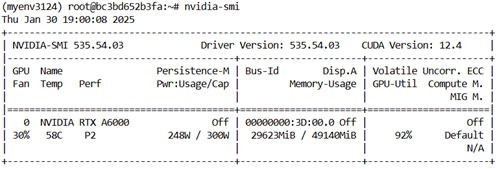

In [42]:
green_scores.to_csv('data/green_scores_Llama-3.2-11B.csv', index=True)

In [43]:
green_scores

,mean,std
CXR3030_IM-1405,0.8,0.0
CXR38_IM-1911,1.0,0.0
...,...,...
CXR2312_IM-0887,0.333333,0.0
CXR49_IM-2110,0.333333,0.0


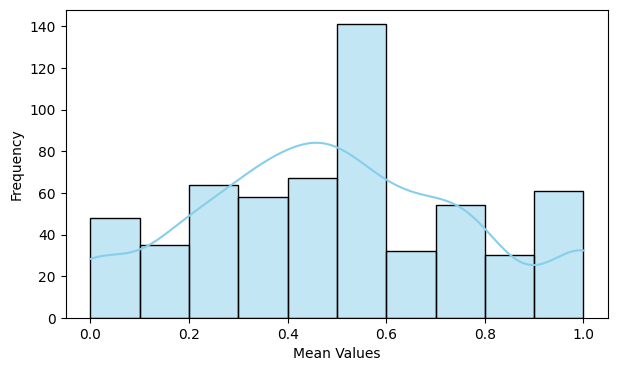

In [ ]:
# Kernel Density Estimate plot

plt.figure(figsize=(7, 4))
sns.histplot(green_scores['mean'], bins=10, kde=True, color='skyblue')
plt.xlabel('Mean Values'); plt.ylabel('Frequency');